
# 👩‍🏫 Cars Dataset — Linear Regression **Teacher's Version (with Answers)**
*Generated on 2025-09-12 03:57:11*

This is the **answer key** for the step-by-step linear regression notebook.  
It includes **solution code** and **Teacher Notes** after each TODO, with typical observations for car datasets (e.g., MPG).

> ⚠️ Outputs (metrics, p-values, best degree) may vary by dataset version and random split. Use the notes as **guidance**, not absolutes.


## 0) Setup

In [1]:

#@title Install & import (safe to re-run)
import sys, subprocess

def pip_install(pkg):
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", pkg], check=False)

pip_install("gdown>=5.1")
pip_install("pandas>=1.5")
pip_install("numpy>=1.23")
pip_install("matplotlib>=3.7")
pip_install("scikit-learn>=1.3")
pip_install("statsmodels>=0.14")

import gdown, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy import stats


## 1) Download & Load the Dataset

In [2]:

#@title Download CSV via gdown
GDOWN_ID = "1bwRmKkPwmLKiqOgQ_LnKH0Vsc3mJKmVR"  # provided ID
OUTPUT_CSV = "cars.csv"

if not os.path.exists(OUTPUT_CSV):
    url = f"https://drive.google.com/uc?id={GDOWN_ID}"
    gdown.download(url, OUTPUT_CSV, quiet=False)
else:
    print("Found existing file:", OUTPUT_CSV)

df = pd.read_csv(OUTPUT_CSV)
print("✅ Loaded:", df.shape)
df.head()


Downloading...
From: https://drive.google.com/uc?id=1bwRmKkPwmLKiqOgQ_LnKH0Vsc3mJKmVR
To: /content/cars.csv
100%|██████████| 1.69M/1.69M [00:00<00:00, 14.3MB/s]


✅ Loaded: (19820, 18)


,selling_price,year,km_driven,mileage,engine,max_power,age,make,model,Individual,Trustmark Dealer,Diesel,Electric,LPG,Petrol,Manual,5,>5
0,1.20,2012.0,120000,19.70,796.0,46.30,11.0,MARUTI,ALTO STD,1,0,0,0,0,1,1,1,0
1,5.50,2016.0,20000,18.90,1197.0,82.00,7.0,HYUNDAI,GRAND I10 ASTA,1,0,0,0,0,1,1,1,0
2,2.15,2010.0,60000,17.00,1197.0,80.00,13.0,HYUNDAI,I20 ASTA,1,0,0,0,0,1,1,1,0
3,2.26,2012.0,37000,20.92,998.0,67.10,11.0,MARUTI,ALTO K10 2010-2014 VXI,1,0,0,0,0,1,1,1,0
4,5.70,2015.0,30000,22.77,1498.0,98.59,8.0,FORD,ECOSPORT 2015-2021 1.5 TDCI TITANIUM BSIV,0,0,1,0,0,0,1,1,0



### 📝 TODO (Student)
Skim the first few rows. What looks like a good **target** (y) for prediction (e.g., `mpg`, `price`)?

**✅ Teacher Notes:**  
- For classic MPG data, **`mpg`** is the standard target for regression.  
- If `price`/`selling_price` exists (on other car datasets), that can also be a valid target.


## 2) Quick Inspect & Simple Cleaning

In [3]:

print("Columns:", list(df.columns))
print("\nData types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())

# Simple cleaning
df.columns = [c.strip().replace(" ", "_") for c in df.columns]
before = df.shape[0]
df = df.drop_duplicates().reset_index(drop=True)
print("\nDropped duplicates:", before - df.shape[0])

# 🔎 Solution example: remove impossible negatives from obviously non-negative cols
nonneg_candidates = [c for c in df.select_dtypes(include=np.number).columns]
removed = 0
for col in nonneg_candidates:
    neg_ct = (df[col] < 0).sum()
    if neg_ct > 0:
        df = df[df[col] >= 0]
        removed += neg_ct
if removed:
    print(f"Removed {removed} rows with negative numeric values.")
print("Shape after cleaning:", df.shape)


Columns: ['selling_price', 'year', 'km_driven', 'mileage', 'engine', 'max_power', 'age', 'make', 'model', 'Individual', 'Trustmark Dealer', 'Diesel', 'Electric', 'LPG', 'Petrol', 'Manual', '5', '>5']

Data types:
 selling_price       float64
year                float64
km_driven             int64
mileage             float64
engine              float64
max_power           float64
age                 float64
make                 object
model                object
Individual            int64
Trustmark Dealer      int64
Diesel                int64
Electric              int64
LPG                   int64
Petrol                int64
Manual                int64
5                     int64
>5                    int64
dtype: object

Missing values per column:
 selling_price       0
year                0
km_driven           0
mileage             0
engine              0
max_power           0
age                 0
make                0
model               0
Individual          0
Trustmark Dealer   


**✅ Teacher Notes:**  
- Duplicates can bias the model; safe to drop.  
- Many car attributes (e.g., `weight`, `horsepower`, `displacement`) **should not be negative**.  
- Optional: mild outlier trimming via **IQR** if plots show extreme points skewing the fit.


## 3) Choose Target and Features (Keep it Simple)

In [4]:

# 👉 Teacher solution: aim for 'mpg' when available
TARGET = "mpg" if "mpg" in df.columns else None

# Fallback to a numeric column if mpg is missing
if TARGET is None:
    numeric_cols_all = df.select_dtypes(include=np.number).columns.tolist()
    TARGET = numeric_cols_all[0]

# Numeric-only features for simplicity
numeric_cols = [c for c in df.select_dtypes(include=np.number).columns if c != TARGET]

print("Target:", TARGET)
print("Numeric features (sample):", numeric_cols[:6])


Target: selling_price
Numeric features (sample): ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'age']



**✅ Teacher Notes:**  
- For MPG-style data: a good starting feature set is:  
  `['displacement','horsepower','weight','acceleration','model_year']` (if present & numeric).  
- If `model_year` is categorical-like, you can still keep it numeric as a proxy for technology improvements.


## 4) Univariate Plots (Matplotlib) + Observations

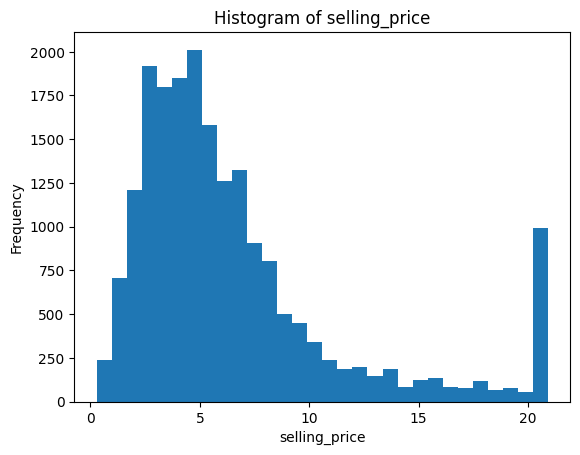

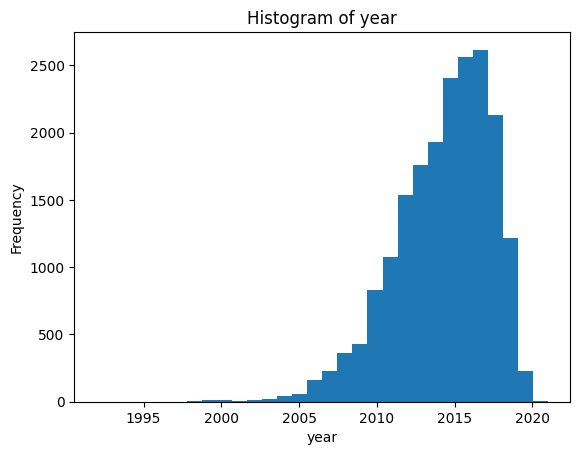

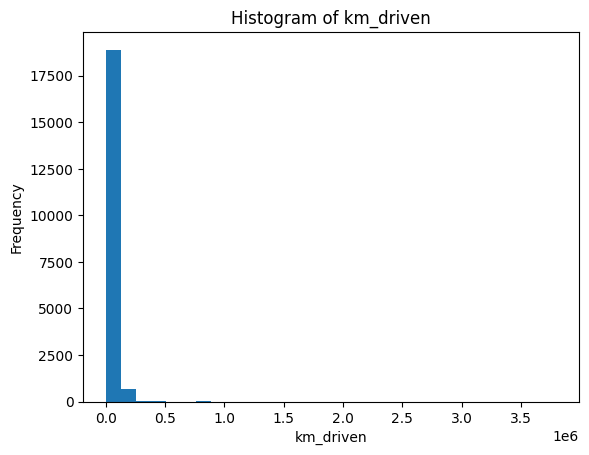

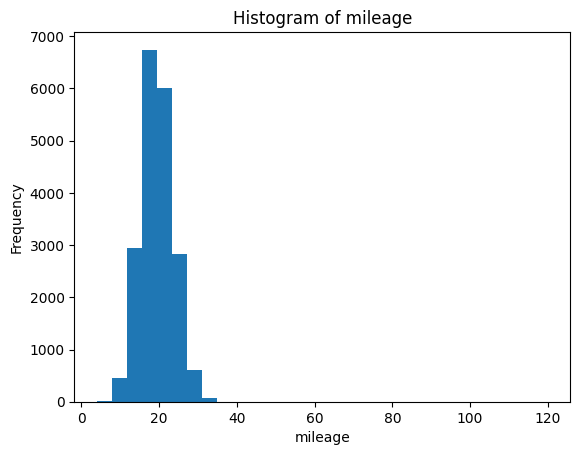

In [5]:

# Target histogram
if TARGET in df.columns and pd.api.types.is_numeric_dtype(df[TARGET]):
    plt.figure()
    df[TARGET].plot(kind='hist', bins=30, title=f"Histogram of {TARGET}")
    plt.xlabel(TARGET); plt.ylabel("Frequency")
    plt.show()

# Up to 3 numeric feature histograms
for col in numeric_cols[:3]:
    plt.figure()
    df[col].plot(kind='hist', bins=30, title=f"Histogram of {col}")
    plt.xlabel(col); plt.ylabel("Frequency")
    plt.show()



**✅ Teacher Notes (typical MPG-patterns):**
- `mpg` often looks roughly normal to slightly right-skewed.  
- `horsepower`, `weight`, and `displacement` commonly show **right-skew**.  
- Outliers: very heavy cars or very high horsepower can appear as tails.


## 5) Single-Variable Linear Regression (Solution)

Feature: year
Slope: 0.5884126624392731 (expect negative with mpg vs horsepower)
Intercept: -1178.8104689625982
R^2 (test): 0.15892947527700096


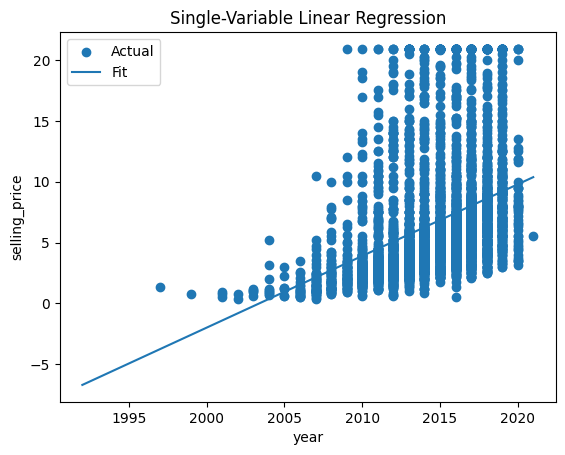

In [6]:

# Pick a dominant predictor: horsepower is a classic for mpg
FEATURE_X = "horsepower" if "horsepower" in numeric_cols else numeric_cols[0]

data_1v = df[[FEATURE_X, TARGET]].dropna().copy()
X = data_1v[[FEATURE_X]].values
y = data_1v[TARGET].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("Feature:", FEATURE_X)
print("Slope:", lr.coef_[0], "(expect negative with mpg vs horsepower)")
print("Intercept:", lr.intercept_)
print("R^2 (test):", r2_score(y_test, y_pred))

# Plot
plt.figure()
plt.scatter(X_test, y_test, label="Actual")
x_line = np.linspace(X.min(), X.max(), 200).reshape(-1,1)
plt.plot(x_line, lr.predict(x_line), label="Fit")
plt.xlabel(FEATURE_X); plt.ylabel(TARGET); plt.title("Single-Variable Linear Regression")
plt.legend(); plt.show()



**✅ Teacher Notes:**  
- **Expected:** For MPG, slope with `horsepower` is **negative** (higher HP → lower MPG).  
- R² for a single feature is moderate (often **0.5–0.7** on classic MPG), but varies.


## 6) Multi-Variable Linear Regression (Solution)

In [11]:
data_mv = df[numeric_cols + [TARGET]].dropna().copy()
X = data_mv[numeric_cols].values
y = data_mv[TARGET].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lin = LinearRegression()
lin.fit(X_train, y_train)
y_pred = lin.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5  # Fix for older sklearn versions
r2 = r2_score(y_test, y_pred)
print(f"MAE:  {mae:.3f}")
print(f"MSE:  {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R^2:  {r2:.3f}")


MAE:  1.609
MSE:  5.627
RMSE: 2.372
R^2:  0.739



**✅ Teacher Notes (typical):**  
- With sensible features, **R² ~ 0.7–0.85** on MPG-like datasets.  
- The improvement over single-variable fits illustrates **multivariate** modeling benefits.


## 7) Diagnostic Plots (Residuals) + Notes

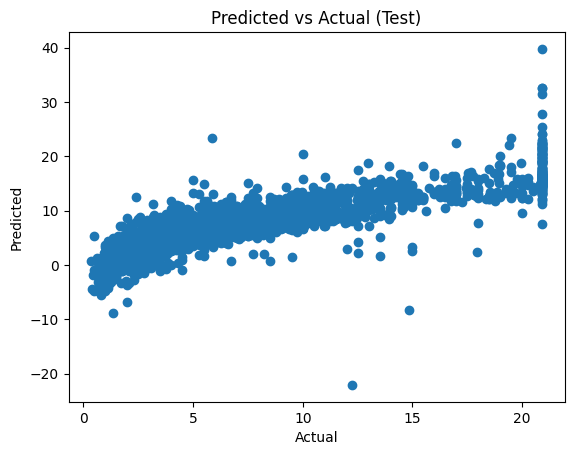

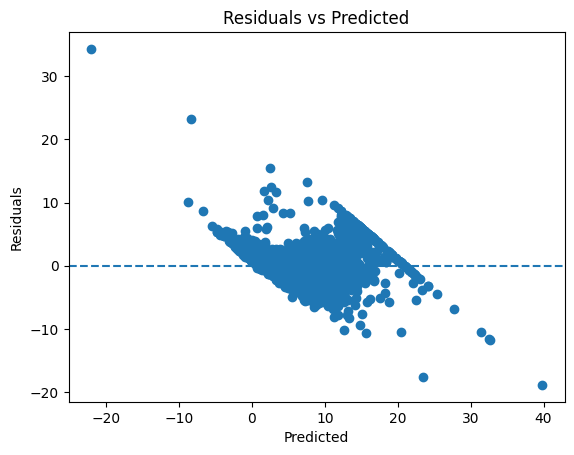

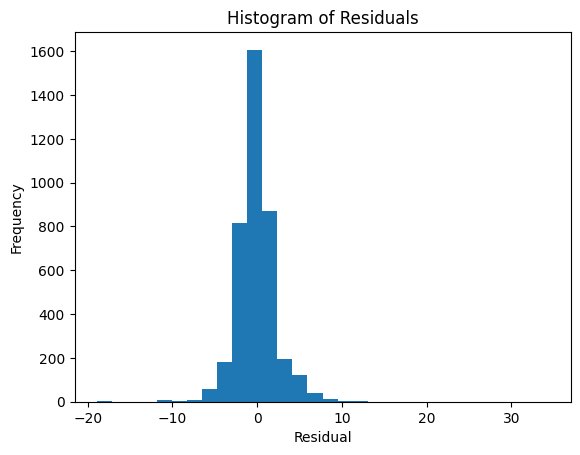

In [12]:

residuals = y_test - y_pred

plt.figure()
plt.scatter(y_test, y_pred)
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.title("Predicted vs Actual (Test)")
plt.show()

plt.figure()
plt.scatter(y_pred, residuals)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted"); plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

plt.figure()
pd.Series(residuals).plot(kind='hist', bins=30, title="Histogram of Residuals")
plt.xlabel("Residual"); plt.ylabel("Frequency")
plt.show()



**✅ Teacher Notes:**  
- We want points centered around 0 with no curves (linearity) and **roughly constant spread** (homoscedasticity).  
- Residuals often look slightly non-normal; acceptable for prediction if performance is good.


## 8) Assumption Checks (Formal) — Solution

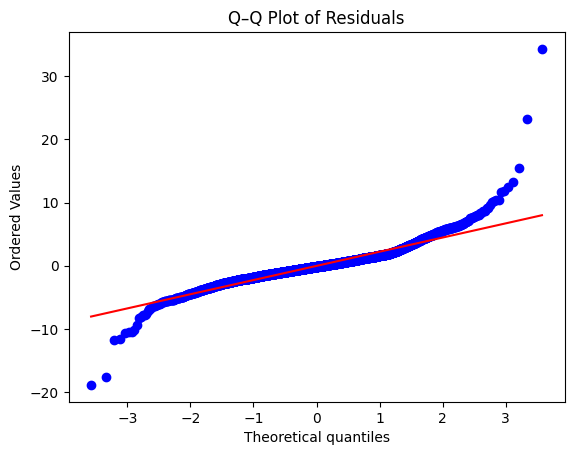

Shapiro–Wilk p-value: 1.89e-45 (p>0.05 ≈ normal residuals)
Durbin–Watson: 1.968 (≈2 is ideal)
Breusch–Pagan p-value: 0 (p>0.05 ≈ constant variance)
             feature         VIF
0               year  382.523724
11            Petrol   17.499619
8             Diesel   16.610718
14                >5   13.024664
13                 5   11.876077
5                age   11.421199
3             engine    6.312178
4          max_power    4.063214
2            mileage    3.118588
12            Manual    1.538234
1          km_driven    1.418832
10               LPG    1.224823
9           Electric    1.155879
6         Individual    1.088828
7   Trustmark_Dealer    1.020722


In [15]:

# Q–Q plot & Shapiro-Wilk (normality)
plt.figure()
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q–Q Plot of Residuals"); plt.show()

sh_stat, sh_p = stats.shapiro(residuals)
print(f"Shapiro–Wilk p-value: {sh_p:.3g} (p>0.05 ≈ normal residuals)")

# Durbin-Watson (autocorrelation)
dw = durbin_watson(residuals)
print(f"Durbin–Watson: {dw:.3f} (≈2 is ideal)")

# Breusch–Pagan test (heteroscedasticity)
X_bp = sm.add_constant(pd.DataFrame(X_test, columns=numeric_cols))
bp_stat, bp_p, _, _ = het_breuschpagan(residuals, X_bp)
print(f"Breusch–Pagan p-value: {bp_p:.3g} (p>0.05 ≈ constant variance)")

# VIF calculation (multicollinearity) — updated to fix index error
X_vif = pd.DataFrame(X_train, columns=numeric_cols).dropna()
X_vif_const = sm.add_constant(X_vif, has_constant='add')

# Remove constant or duplicate columns before VIF calculation if necessary
X_vif_noconst = X_vif_const.loc[:, X_vif_const.nunique() > 1]

vif_vals = []
for i, col in enumerate(X_vif_noconst.columns):
    if col == 'const':
        continue  # Skip intercept
    # Note: i is used here, which matches column index
    vif = variance_inflation_factor(X_vif_noconst.values, i)
    vif_vals.append({"feature": col, "VIF": vif})

vif_df = pd.DataFrame(vif_vals).sort_values("VIF", ascending=False)
print(vif_df)



**✅ Teacher Notes (rules of thumb):**  
- **Shapiro p > 0.05** → residuals near normal (for inference).  
- **Durbin–Watson ≈ 2** → little autocorrelation (OK for cross-sectional data).  
- **Breusch–Pagan p > 0.05** → homoscedasticity not rejected.  
- **VIF > 10** → severe multicollinearity; consider dropping/combining features.


## 9) Polynomial Features + Grid Search (Best Degree) — Solution

Best params: {'lr__fit_intercept': True, 'poly__degree': 2}
Best CV R^2: 0.13901180883987313


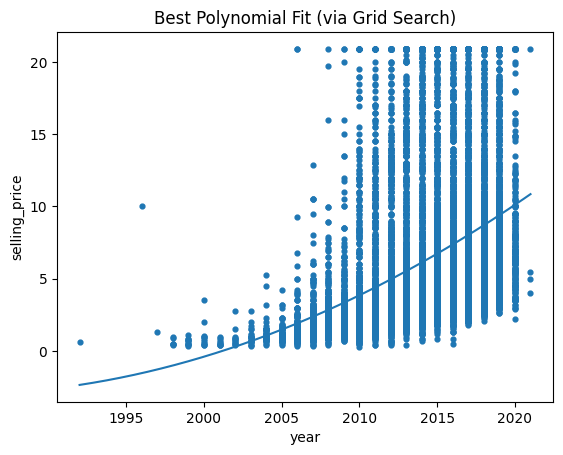

In [16]:

FEATURE_X = "horsepower" if "horsepower" in numeric_cols else numeric_cols[0]

poly_data = df[[FEATURE_X, TARGET]].dropna().copy()
X = poly_data[[FEATURE_X]].values
y = poly_data[TARGET].values

pipe = Pipeline([("poly", PolynomialFeatures(include_bias=False)),
                 ("lr", LinearRegression())])

param_grid = {
    "poly__degree": [1, 2, 3, 4, 5],
    "lr__fit_intercept": [True, False]
}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring="r2", n_jobs=-1)
grid.fit(X, y)

print("Best params:", grid.best_params_)
print("Best CV R^2:", grid.best_score_)

best_model = grid.best_estimator_
x_line = np.linspace(X.min(), X.max(), 200).reshape(-1,1)
y_line = best_model.predict(x_line)

plt.figure()
plt.scatter(X, y, s=12)
plt.plot(x_line, y_line)
plt.xlabel(FEATURE_X); plt.ylabel(TARGET)
plt.title("Best Polynomial Fit (via Grid Search)")
plt.show()



**✅ Teacher Notes (typical):**  
- For MPG vs `horsepower`, **degree 2 or 3** often performs best.  
- Higher degrees (>5) rarely help and can overfit (wiggly curves).


## 10) Coefficient Interpretation — Solution

In [17]:

coef = lin.coef_
coef_df = pd.DataFrame({"feature": numeric_cols, "coefficient": coef})
coef_df["abs_coef"] = coef_df["coefficient"].abs()
coef_df.sort_values("abs_coef", ascending=False, inplace=True)
coef_df.drop(columns=["abs_coef"], inplace=True)
coef_df.head(10)


,feature,coefficient
9,Electric,9.255519
12,Manual,-2.551030
11,Petrol,-1.434426
8,Diesel,0.548122
14,>5,-0.523208
13,5,-0.423675
7,Trustmark_Dealer,-0.400454
6,Individual,-0.348641
0,year,0.256518
5,age,-0.256518



**✅ Teacher Notes (MPG-style):**  
- **weight** and **horsepower** tend to have **negative** coefficients (heavier/more powerful → lower mpg).  
- **acceleration** may be **positive**.  
- **model_year** (if numeric) often **positive** (newer cars more efficient).


## 11) Cross-Validated Performance (K-Fold) — Solution

In [18]:

data_mv = df[numeric_cols + [TARGET]].dropna().copy()
X = data_mv[numeric_cols].values
y = data_mv[TARGET].values

cv = KFold(n_splits=5, shuffle=True, random_state=42)
lr_cv = LinearRegression()

r2_cv = cross_val_score(lr_cv, X, y, scoring="r2", cv=cv)
neg_mse_cv = cross_val_score(lr_cv, X, y, scoring="neg_mean_squared_error", cv=cv)
rmse_cv = (-neg_mse_cv) ** 0.5

print("R^2 CV:  mean={:.3f}, std={:.3f}".format(r2_cv.mean(), r2_cv.std()))
print("RMSE CV: mean={:.3f}, std={:.3f}".format(rmse_cv.mean(), rmse_cv.std()))


R^2 CV:  mean=0.772, std=0.019
RMSE CV: mean=2.296, std=0.045



**✅ Teacher Notes (typical):**  
- Expect **R² mean ~0.7–0.85** with modest std.  
- CV highlights stability vs a single split.


## 12) Statsmodels OLS + 95% Confidence Intervals — Solution

In [19]:

# Fit OLS on train split from section 6
X_train_df = pd.DataFrame(X_train, columns=numeric_cols)
X_train_ols = sm.add_constant(X_train_df, has_constant='add')
ols_model = sm.OLS(y_train, X_train_ols).fit()
print(ols_model.summary())

ci = ols_model.conf_int(alpha=0.05)
ci.columns = ["CI_lower", "CI_upper"]
ci


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     4059.
Date:                Fri, 12 Sep 2025   Prob (F-statistic):               0.00
Time:                        04:09:53   Log-Likelihood:                -35178.
No. Observations:               15728   AIC:                         7.039e+04
Df Residuals:                   15713   BIC:                         7.050e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0002   3.31e-06  

,CI_lower,CI_upper
const,-0.000255,-0.000242
year,0.005253,0.005941
km_driven,-0.000010,-0.000008
mileage,-0.164046,-0.134865
engine,0.000716,0.001062
max_power,0.046912,0.050120
age,-0.520677,-0.494200
Individual,-0.424436,-0.272847
Trustmark_Dealer,-0.763895,-0.037013
Diesel,0.259349,0.836895



**✅ Teacher Notes:**  
- CIs that **exclude 0** indicate significant association (under OLS assumptions).  
- Signs should match sklearn coefficients (differences in scaling may slightly change magnitudes).


## 13) Learning Curve (Bias/Variance) — Solution

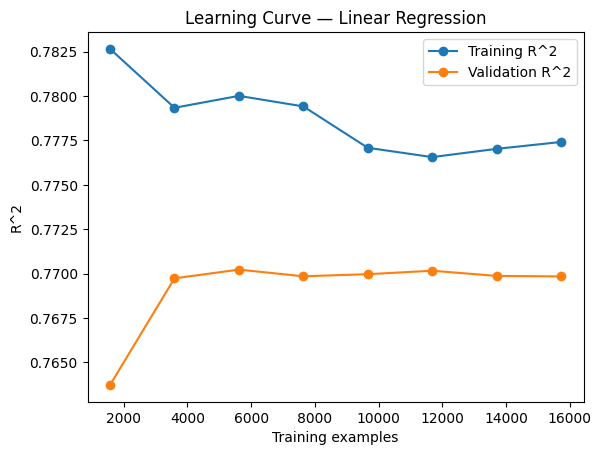

In [20]:

data_mv = df[numeric_cols + [TARGET]].dropna().copy()
X = data_mv[numeric_cols].values
y = data_mv[TARGET].values

train_sizes, train_scores, val_scores = learning_curve(
    LinearRegression(), X, y, cv=5, scoring="r2",
    train_sizes=np.linspace(0.1, 1.0, 8), shuffle=True, random_state=42
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, marker='o', label='Training R^2')
plt.plot(train_sizes, val_mean, marker='o', label='Validation R^2')
plt.xlabel("Training examples"); plt.ylabel("R^2")
plt.title("Learning Curve — Linear Regression")
plt.legend(); plt.show()



**✅ Teacher Notes:**  
- If both curves low and close → **high bias** (underfit).  
- If a gap persists → **variance**; more data or feature engineering may help.
